In [2]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

print(train.columns.values)
corrmat = train.corr()

fig = plt.figure(figsize=(12,9))
sns.heatmap(corrmat, vmax=.8, square=True)



['Id' 'MSSubClass' 'MSZoning' 'LotFrontage' 'LotArea' 'Street' 'Alley'
 'LotShape' 'LandContour' 'Utilities' 'LotConfig' 'LandSlope'
 'Neighborhood' 'Condition1' 'Condition2' 'BldgType' 'HouseStyle'
 'OverallQual' 'OverallCond' 'YearBuilt' 'YearRemodAdd' 'RoofStyle'
 'RoofMatl' 'Exterior1st' 'Exterior2nd' 'MasVnrType' 'MasVnrArea'
 'ExterQual' 'ExterCond' 'Foundation' 'BsmtQual' 'BsmtCond' 'BsmtExposure'
 'BsmtFinType1' 'BsmtFinSF1' 'BsmtFinType2' 'BsmtFinSF2' 'BsmtUnfSF'
 'TotalBsmtSF' 'Heating' 'HeatingQC' 'CentralAir' 'Electrical' '1stFlrSF'
 '2ndFlrSF' 'LowQualFinSF' 'GrLivArea' 'BsmtFullBath' 'BsmtHalfBath'
 'FullBath' 'HalfBath' 'BedroomAbvGr' 'KitchenAbvGr' 'KitchenQual'
 'TotRmsAbvGrd' 'Functional' 'Fireplaces' 'FireplaceQu' 'GarageType'
 'GarageYrBlt' 'GarageFinish' 'GarageCars' 'GarageArea' 'GarageQual'
 'GarageCond' 'PavedDrive' 'WoodDeckSF' 'OpenPorchSF' 'EnclosedPorch'
 '3SsnPorch' 'ScreenPorch' 'PoolArea' 'PoolQC' 'Fence' 'MiscFeature'
 'MiscVal' 'MoSold' 'YrSold' 'SaleTy

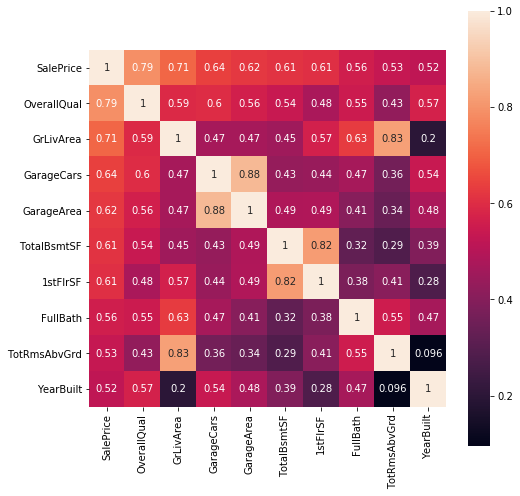

In [3]:
#find most correlated features
corrmat = abs(corrmat)
cols = corrmat.nlargest(10, "SalePrice")["SalePrice"].index
corrmat = train[cols].corr()
fig = plt.figure(figsize=(8,8))
sns.heatmap(corrmat, square=True, annot=True)


/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


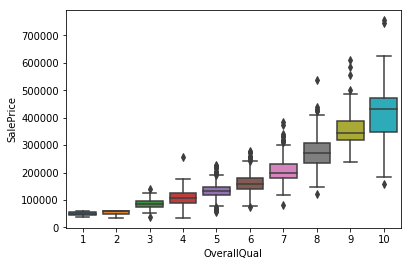

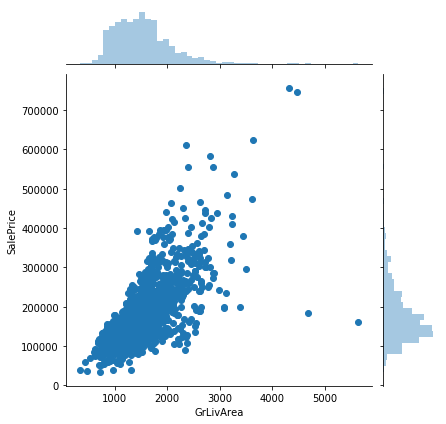

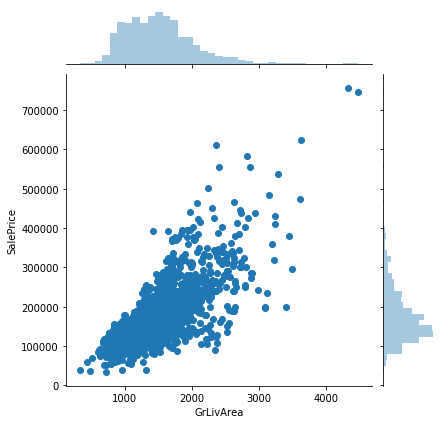

In [4]:
#Let's remove outliers from features most correlated with saleprice since
# they may degrade performance

#nothing strange here: if qual increase then so does saleprice
sns.boxplot(data=train, x = "OverallQual", y = "SalePrice")
#here have 2 outliers: GrLivArea >= 4000 and saleprice <= 300000
sns.jointplot(data=train, x="GrLivArea", y="SalePrice")
train = train.loc[~((train["GrLivArea"] >= 4000) & (train["SalePrice"] <= 300000))]
#now looks better
sns.jointplot(data=train, x="GrLivArea", y="SalePrice")

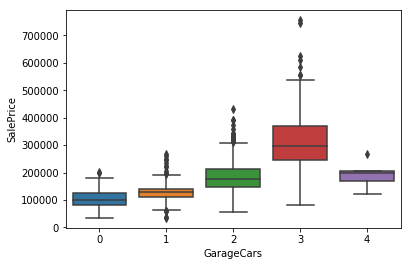

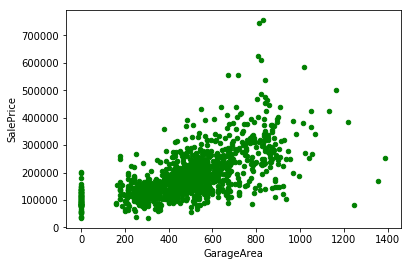

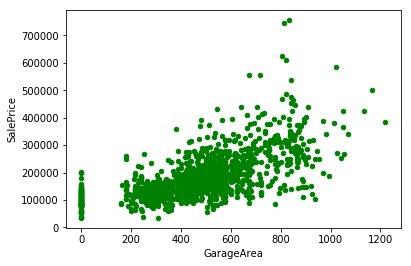

In [5]:
#So when can fit 4 cars in garage then suddenly price goes down?
#remove this outlier!
sns.boxplot(x = "GarageCars", y = "SalePrice", data=train)
train.plot(kind="scatter", x = "GarageArea", y="SalePrice", color="green")
train = train[~((train["GarageArea"] >= 1200) & (train["SalePrice"] <= 300000))]
#now this looks better
train.plot(kind="scatter", x = "GarageArea", y="SalePrice", color="green")


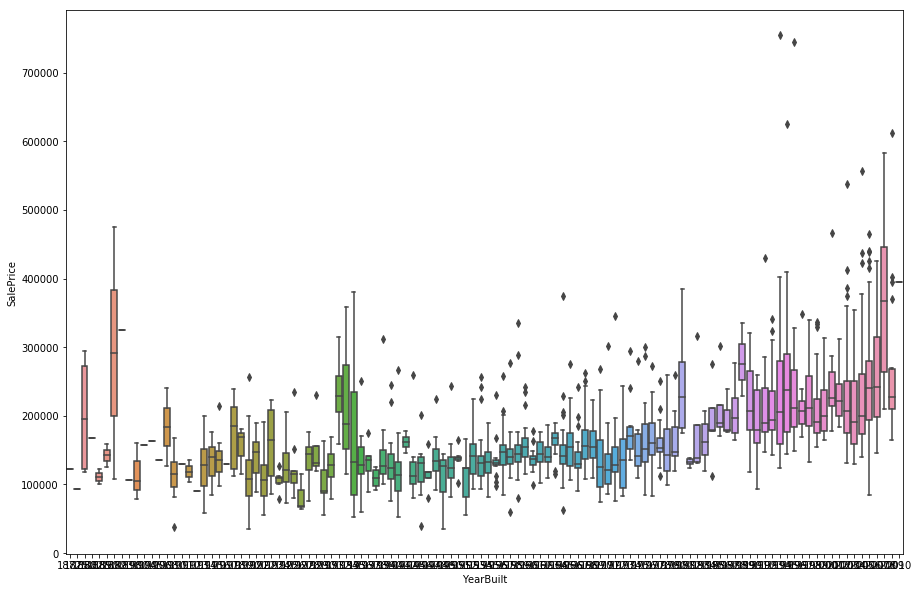

In [6]:

fig = plt.figure(figsize=(15,10))
sns.boxplot(data=train, x = "YearBuilt", y="SalePrice")
#house prices should increase with year due to inflation

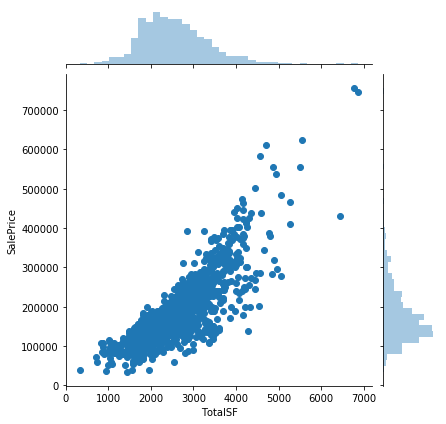

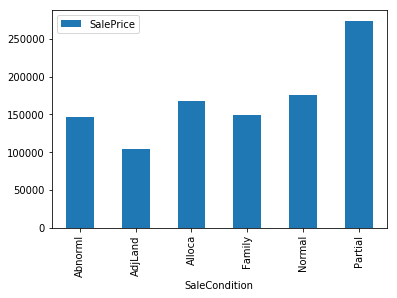

In [7]:
train['TotalSF'] = train['TotalBsmtSF'] + train['1stFlrSF'] + train['2ndFlrSF']

sns.jointplot(x = "TotalSF", y="SalePrice", data=train)
test['TotalSF'] = test['TotalBsmtSF'] + test['1stFlrSF'] + test['2ndFlrSF']

temp = train[["SalePrice", "SaleCondition"]].groupby(["SaleCondition"]).mean()
temp.plot(kind="bar")
##we see that partial has higher average saleprice than the other groups
##perhaps then can replace this feature with 1 or 0 for partial.
##With OHE for this category this is basically feaure selection but since we do lasso
##we dont need to do this, lasso does it for us. However, if want to use normal linear regression
##then this could be a good idea

258
Index(['LotFrontage', '1stFlrSF', 'MSSubClass', 'TotalSF', 'LotArea',
       'SalePrice', 'GrLivArea', 'TotRmsAbvGrd', 'TotalBsmtSF', 'GarageArea'],
      dtype='object')
0
0
0


/usr/local/lib/python3.7/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


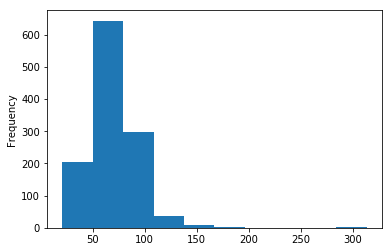

In [8]:

from sklearn.tree import DecisionTreeRegressor

print(sum(train["LotFrontage"].isnull()*1))
#so this numerical feature has 258 missing features, which is about 18% of all data
#filling it in with mean could be bad since mean may not accurately estimate the expected value of LotFrontage

corrmat = abs(train.corr())
print(corrmat.nlargest(10, "LotFrontage")["LotFrontage"].index)
print(sum(train["TotalSF"].isnull()*1))
print(sum(train["MSSubClass"].isnull()*1))
print(sum(train["GarageArea"].isnull()*1))

#TotalSF, MSSubClass and Garagearea are highly correlated with LotFrontage and have no missing values
#note, however, that they have missing values in test set so have to deal with this

train_temp = train[["TotalSF", "MSSubClass", "GarageArea", "LotFrontage"]]
train_temp_1 = train_temp[train["LotFrontage"].notnull()]
train_temp_1_X = train_temp_1[["TotalSF", "MSSubClass", "GarageArea"]]
train_temp_1_Y = train_temp_1["LotFrontage"]

train_temp_2_X = train_temp[train["LotFrontage"].isnull()]
train_temp_2_X.drop("LotFrontage", axis=1, inplace=True)

train_temp_1_Y.plot(kind="hist") #doesn't look skewed so ok!

linear_regression = DecisionTreeRegressor()
linear_regression.fit(train_temp_1_X, train_temp_1_Y)

train_temp_2_Y = linear_regression.predict(train_temp_2_X) #returns numpy array
train.loc[train["LotFrontage"].isnull(), "LotFrontage"] = train_temp_2_Y



In [9]:
print(train.shape)
print(test.shape)


(1455, 82)
(1459, 81)


In [10]:
test["SalePrice"] = 0
df = train.append(test)
df = pd.get_dummies(df) #transform all non numeric (object) features to categorical using one-hot encoding
# if NaN then just zeros 
train = df[:1455].copy()
test = df[1455:].copy()
test.drop("SalePrice", axis=1, inplace=True)
print(train.columns.values)

['1stFlrSF' '2ndFlrSF' '3SsnPorch' 'BedroomAbvGr' 'BsmtFinSF1'
 'BsmtFinSF2' 'BsmtFullBath' 'BsmtHalfBath' 'BsmtUnfSF' 'EnclosedPorch'
 'Fireplaces' 'FullBath' 'GarageArea' 'GarageCars' 'GarageYrBlt'
 'GrLivArea' 'HalfBath' 'Id' 'KitchenAbvGr' 'LotArea' 'LotFrontage'
 'LowQualFinSF' 'MSSubClass' 'MasVnrArea' 'MiscVal' 'MoSold' 'OpenPorchSF'
 'OverallCond' 'OverallQual' 'PoolArea' 'SalePrice' 'ScreenPorch'
 'TotRmsAbvGrd' 'TotalBsmtSF' 'TotalSF' 'WoodDeckSF' 'YearBuilt'
 'YearRemodAdd' 'YrSold' 'Alley_Grvl' 'Alley_Pave' 'BldgType_1Fam'
 'BldgType_2fmCon' 'BldgType_Duplex' 'BldgType_Twnhs' 'BldgType_TwnhsE'
 'BsmtCond_Fa' 'BsmtCond_Gd' 'BsmtCond_Po' 'BsmtCond_TA' 'BsmtExposure_Av'
 'BsmtExposure_Gd' 'BsmtExposure_Mn' 'BsmtExposure_No' 'BsmtFinType1_ALQ'
 'BsmtFinType1_BLQ' 'BsmtFinType1_GLQ' 'BsmtFinType1_LwQ'
 'BsmtFinType1_Rec' 'BsmtFinType1_Unf' 'BsmtFinType2_ALQ'
 'BsmtFinType2_BLQ' 'BsmtFinType2_GLQ' 'BsmtFinType2_LwQ'
 'BsmtFinType2_Rec' 'BsmtFinType2_Unf' 'BsmtQual_Ex' 'BsmtQual_F

/usr/local/lib/python3.7/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


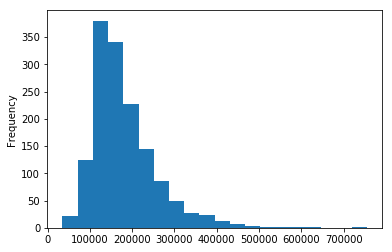

In [11]:
train["SalePrice"].plot(kind="hist", bins=20) #slightly skewed (not symmetric --> bad for regression) so transform it
train["SalePrice"] = np.log1p(train["SalePrice"])


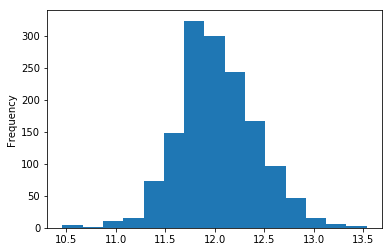

In [12]:
train["SalePrice"].plot(kind="hist", bins=15)


In [13]:
fill_ins = train.mean()
train.fillna(fill_ins, inplace=True)


In [14]:
test["TotalSF"].fillna(train["TotalSF"].mean(), inplace=True)
test["GarageArea"].fillna(train["GarageArea"].mean(), inplace=True)

temp = test[test["LotFrontage"].isnull()]
test_2_X = temp[["TotalSF", "MSSubClass", "GarageArea"]]
preds = linear_regression.predict(test_2_X)
test.loc[test["LotFrontage"].isnull(), "LotFrontage"] = preds

test.fillna(fill_ins, inplace=True)
#remember that we predict log(SalePrice+1) so to get real saleprice need to take e^y-1

In [15]:
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error

X_train = train.drop("SalePrice", axis=1)
Y_train = train["SalePrice"]

def rmse(actual, predict):
    return np.sqrt(mean_squared_error(actual, predict))

rmse_score = make_scorer(rmse, greater_is_better=False)

lasso = linear_model.Lasso()

params = {"alpha": [1, 0.1, 0.001, 0.0005, 0.0001]}
gs = GridSearchCV(lasso, cv = 10, param_grid = params, scoring=rmse_score)
gs.fit(X_train, Y_train)



/Users/andreas/Library/Python/3.7/lib/python/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3143326906100885, tolerance: 0.02111607972266252
  positive)
/Users/andreas/Library/Python/3.7/lib/python/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.09744673736987863, tolerance: 0.020930992848873276
  positive)
/Users/andreas/Library/Python/3.7/lib/python/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.1923050745045582, tolerance: 0.020578300294041597
  positive)
/Users/andreas/Library/Python/3.7/lib/python/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not 

/Users/andreas/Library/Python/3.7/lib/python/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.11768505048670796, tolerance: 0.02320893121833208
  positive)


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'alpha': [1, 0.1, 0.001, 0.0005, 0.0001]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(rmse, greater_is_better=False), verbose=0)

In [16]:
print(gs.best_params_)
print(-1*gs.best_score_)

lasso = linear_model.Lasso(alpha = 0.0005)
lasso.fit(X_train, Y_train)

preds = lasso.predict(test)
preds = np.exp(preds)-1

submit = pd.DataFrame({"Id": test["Id"], "SalePrice": preds})
submit.to_csv("/Users/andreas/Documents/workspace/kaggle/house_prices/submit.csv", index=False) #don't include indices


{'alpha': 0.0005}
0.11084114642121838


/Users/andreas/Library/Python/3.7/lib/python/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.11768505048670796, tolerance: 0.02320893121833208
  positive)


In [286]:
import xgboost as xgb


xgb = xgb.XGBRegressor()
params = { 'learning_rate': [.03, 0.05], #so called `eta` value
              'max_depth': [6, 7,8],
              'n_estimators': [400,500]}

gs = GridSearchCV(xgb, param_grid=params, cv=10, scoring = rmse_score, verbose=10)
gs.fit(X_train, Y_train)

Fitting 10 folds for each of 12 candidates, totalling 120 fits
[CV] learning_rate=0.03, max_depth=6, n_estimators=400 ...............
[22:13:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  learning_rate=0.03, max_depth=6, n_estimators=400, score=-0.11984322594071384, total=   9.8s
[CV] learning_rate=0.03, max_depth=6, n_estimators=400 ...............
[22:13:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.9s remaining:    0.0s
/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.03, max_depth=6, n_estimators=400, score=-0.10312976480236138, total=   9.8s
[CV] learning_rate=0.03, max_depth=6, n_estimators=400 ...............
[22:13:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   19.7s remaining:    0.0s
/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.03, max_depth=6, n_estimators=400, score=-0.11231384658894286, total=  10.1s
[CV] learning_rate=0.03, max_depth=6, n_estimators=400 ...............
[22:13:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   29.9s remaining:    0.0s
/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.03, max_depth=6, n_estimators=400, score=-0.13114723152028188, total=   9.8s
[CV] learning_rate=0.03, max_depth=6, n_estimators=400 ...............
[22:13:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   39.7s remaining:    0.0s
/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.03, max_depth=6, n_estimators=400, score=-0.14325396145212937, total=   9.9s
[CV] learning_rate=0.03, max_depth=6, n_estimators=400 ...............
[22:13:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   49.7s remaining:    0.0s
/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.03, max_depth=6, n_estimators=400, score=-0.10517176530569644, total=  10.1s
[CV] learning_rate=0.03, max_depth=6, n_estimators=400 ...............
[22:14:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   59.8s remaining:    0.0s
/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.03, max_depth=6, n_estimators=400, score=-0.1165473068032768, total=  10.2s
[CV] learning_rate=0.03, max_depth=6, n_estimators=400 ...............
[22:14:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  1.2min remaining:    0.0s
/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.03, max_depth=6, n_estimators=400, score=-0.10843442227587394, total=  10.4s
[CV] learning_rate=0.03, max_depth=6, n_estimators=400 ...............
[22:14:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  1.3min remaining:    0.0s
/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.03, max_depth=6, n_estimators=400, score=-0.10204965155928257, total=   9.8s
[CV] learning_rate=0.03, max_depth=6, n_estimators=400 ...............
[22:14:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  1.5min remaining:    0.0s
/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.03, max_depth=6, n_estimators=400, score=-0.13944264651659152, total=   9.7s
[CV] learning_rate=0.03, max_depth=6, n_estimators=500 ...............
[22:14:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.03, max_depth=6, n_estimators=500, score=-0.11883878132085703, total=  12.5s
[CV] learning_rate=0.03, max_depth=6, n_estimators=500 ...............
[22:15:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.03, max_depth=6, n_estimators=500, score=-0.10247034524786705, total=  12.4s
[CV] learning_rate=0.03, max_depth=6, n_estimators=500 ...............
[22:15:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.03, max_depth=6, n_estimators=500, score=-0.11113932398030503, total=  12.3s
[CV] learning_rate=0.03, max_depth=6, n_estimators=500 ...............
[22:15:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.03, max_depth=6, n_estimators=500, score=-0.13220922676947358, total=  12.3s
[CV] learning_rate=0.03, max_depth=6, n_estimators=500 ...............
[22:15:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.03, max_depth=6, n_estimators=500, score=-0.14287710192358372, total=  12.7s
[CV] learning_rate=0.03, max_depth=6, n_estimators=500 ...............
[22:15:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.03, max_depth=6, n_estimators=500, score=-0.10402796226891012, total=  12.6s
[CV] learning_rate=0.03, max_depth=6, n_estimators=500 ...............
[22:16:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.03, max_depth=6, n_estimators=500, score=-0.11559762532024472, total=  12.3s
[CV] learning_rate=0.03, max_depth=6, n_estimators=500 ...............
[22:16:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.03, max_depth=6, n_estimators=500, score=-0.10773349940869865, total=  12.4s
[CV] learning_rate=0.03, max_depth=6, n_estimators=500 ...............
[22:16:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.03, max_depth=6, n_estimators=500, score=-0.10151845960128977, total=  12.8s
[CV] learning_rate=0.03, max_depth=6, n_estimators=500 ...............
[22:16:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.03, max_depth=6, n_estimators=500, score=-0.13960724487663428, total=  12.9s
[CV] learning_rate=0.03, max_depth=7, n_estimators=400 ...............
[22:16:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.03, max_depth=7, n_estimators=400, score=-0.1235084592126528, total=  10.8s
[CV] learning_rate=0.03, max_depth=7, n_estimators=400 ...............
[22:17:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.03, max_depth=7, n_estimators=400, score=-0.10239977073578338, total=  10.8s
[CV] learning_rate=0.03, max_depth=7, n_estimators=400 ...............
[22:17:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.03, max_depth=7, n_estimators=400, score=-0.1139306255415452, total=  11.4s
[CV] learning_rate=0.03, max_depth=7, n_estimators=400 ...............
[22:17:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.03, max_depth=7, n_estimators=400, score=-0.1313154066394916, total=  11.2s
[CV] learning_rate=0.03, max_depth=7, n_estimators=400 ...............
[22:17:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.03, max_depth=7, n_estimators=400, score=-0.1427107343169403, total=  11.0s
[CV] learning_rate=0.03, max_depth=7, n_estimators=400 ...............
[22:17:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.03, max_depth=7, n_estimators=400, score=-0.10595927437383035, total=  11.0s
[CV] learning_rate=0.03, max_depth=7, n_estimators=400 ...............
[22:18:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.03, max_depth=7, n_estimators=400, score=-0.11691748170592296, total=  12.9s
[CV] learning_rate=0.03, max_depth=7, n_estimators=400 ...............
[22:18:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.03, max_depth=7, n_estimators=400, score=-0.10432444718430578, total=  11.9s
[CV] learning_rate=0.03, max_depth=7, n_estimators=400 ...............
[22:18:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.03, max_depth=7, n_estimators=400, score=-0.10042800460091918, total=  11.5s
[CV] learning_rate=0.03, max_depth=7, n_estimators=400 ...............
[22:18:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.03, max_depth=7, n_estimators=400, score=-0.14266610917711872, total=  11.1s
[CV] learning_rate=0.03, max_depth=7, n_estimators=500 ...............
[22:18:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.03, max_depth=7, n_estimators=500, score=-0.12289258508618285, total=  14.4s
[CV] learning_rate=0.03, max_depth=7, n_estimators=500 ...............
[22:19:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.03, max_depth=7, n_estimators=500, score=-0.10176352228311189, total=  15.3s
[CV] learning_rate=0.03, max_depth=7, n_estimators=500 ...............
[22:19:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.03, max_depth=7, n_estimators=500, score=-0.11309160679419539, total=  13.8s
[CV] learning_rate=0.03, max_depth=7, n_estimators=500 ...............
[22:19:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.03, max_depth=7, n_estimators=500, score=-0.1313481603227091, total=  13.9s
[CV] learning_rate=0.03, max_depth=7, n_estimators=500 ...............
[22:19:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.03, max_depth=7, n_estimators=500, score=-0.1420988816083963, total=  13.8s
[CV] learning_rate=0.03, max_depth=7, n_estimators=500 ...............
[22:20:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.03, max_depth=7, n_estimators=500, score=-0.10482615124179916, total=  14.0s
[CV] learning_rate=0.03, max_depth=7, n_estimators=500 ...............
[22:20:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.03, max_depth=7, n_estimators=500, score=-0.11613188390575901, total=  14.0s
[CV] learning_rate=0.03, max_depth=7, n_estimators=500 ...............
[22:20:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.03, max_depth=7, n_estimators=500, score=-0.10393671570164616, total=  13.8s
[CV] learning_rate=0.03, max_depth=7, n_estimators=500 ...............
[22:20:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.03, max_depth=7, n_estimators=500, score=-0.10032892831573352, total=  13.9s
[CV] learning_rate=0.03, max_depth=7, n_estimators=500 ...............
[22:20:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.03, max_depth=7, n_estimators=500, score=-0.1428045356508549, total=  13.8s
[CV] learning_rate=0.03, max_depth=8, n_estimators=400 ...............
[22:21:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.03, max_depth=8, n_estimators=400, score=-0.12279342083853141, total=  12.3s
[CV] learning_rate=0.03, max_depth=8, n_estimators=400 ...............
[22:21:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.03, max_depth=8, n_estimators=400, score=-0.10673503733941431, total=  11.9s
[CV] learning_rate=0.03, max_depth=8, n_estimators=400 ...............
[22:21:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.03, max_depth=8, n_estimators=400, score=-0.11692884439077439, total=  11.8s
[CV] learning_rate=0.03, max_depth=8, n_estimators=400 ...............
[22:21:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.03, max_depth=8, n_estimators=400, score=-0.13271655678559033, total=  11.8s
[CV] learning_rate=0.03, max_depth=8, n_estimators=400 ...............
[22:21:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.03, max_depth=8, n_estimators=400, score=-0.14369863764190322, total=  11.8s
[CV] learning_rate=0.03, max_depth=8, n_estimators=400 ...............
[22:22:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.03, max_depth=8, n_estimators=400, score=-0.10761556826170589, total=  11.8s
[CV] learning_rate=0.03, max_depth=8, n_estimators=400 ...............
[22:22:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.03, max_depth=8, n_estimators=400, score=-0.11646937485198755, total=  11.9s
[CV] learning_rate=0.03, max_depth=8, n_estimators=400 ...............
[22:22:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.03, max_depth=8, n_estimators=400, score=-0.10669944700191582, total=  11.9s
[CV] learning_rate=0.03, max_depth=8, n_estimators=400 ...............
[22:22:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.03, max_depth=8, n_estimators=400, score=-0.10162739982599481, total=  12.1s
[CV] learning_rate=0.03, max_depth=8, n_estimators=400 ...............
[22:22:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.03, max_depth=8, n_estimators=400, score=-0.14095153992949053, total=  13.2s
[CV] learning_rate=0.03, max_depth=8, n_estimators=500 ...............
[22:23:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.03, max_depth=8, n_estimators=500, score=-0.12251626864826298, total=  16.8s
[CV] learning_rate=0.03, max_depth=8, n_estimators=500 ...............
[22:23:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.03, max_depth=8, n_estimators=500, score=-0.10630155789881988, total=  16.3s
[CV] learning_rate=0.03, max_depth=8, n_estimators=500 ...............
[22:23:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.03, max_depth=8, n_estimators=500, score=-0.11615558910236513, total=  16.1s
[CV] learning_rate=0.03, max_depth=8, n_estimators=500 ...............
[22:24:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.03, max_depth=8, n_estimators=500, score=-0.13261957590017037, total=  15.7s
[CV] learning_rate=0.03, max_depth=8, n_estimators=500 ...............
[22:24:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.03, max_depth=8, n_estimators=500, score=-0.14334642250764004, total=  15.7s
[CV] learning_rate=0.03, max_depth=8, n_estimators=500 ...............
[22:24:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.03, max_depth=8, n_estimators=500, score=-0.10702515685076493, total=  15.3s
[CV] learning_rate=0.03, max_depth=8, n_estimators=500 ...............
[22:24:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.03, max_depth=8, n_estimators=500, score=-0.11612866080772352, total=  15.3s
[CV] learning_rate=0.03, max_depth=8, n_estimators=500 ...............
[22:25:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.03, max_depth=8, n_estimators=500, score=-0.10630729105576497, total=  15.8s
[CV] learning_rate=0.03, max_depth=8, n_estimators=500 ...............
[22:25:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.03, max_depth=8, n_estimators=500, score=-0.10115766029837543, total=  15.3s
[CV] learning_rate=0.03, max_depth=8, n_estimators=500 ...............
[22:25:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.03, max_depth=8, n_estimators=500, score=-0.14114652632591682, total=  15.3s
[CV] learning_rate=0.05, max_depth=6, n_estimators=400 ...............
[22:25:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.05, max_depth=6, n_estimators=400, score=-0.11978027983198947, total=  10.0s
[CV] learning_rate=0.05, max_depth=6, n_estimators=400 ...............
[22:26:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.05, max_depth=6, n_estimators=400, score=-0.10001540094428168, total=  10.9s
[CV] learning_rate=0.05, max_depth=6, n_estimators=400 ...............
[22:26:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.05, max_depth=6, n_estimators=400, score=-0.1094657497689918, total=  13.0s
[CV] learning_rate=0.05, max_depth=6, n_estimators=400 ...............
[22:26:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.05, max_depth=6, n_estimators=400, score=-0.13262139138560816, total=  11.8s
[CV] learning_rate=0.05, max_depth=6, n_estimators=400 ...............
[22:26:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.05, max_depth=6, n_estimators=400, score=-0.1431186848900318, total=  10.1s
[CV] learning_rate=0.05, max_depth=6, n_estimators=400 ...............
[22:26:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.05, max_depth=6, n_estimators=400, score=-0.1003723070898226, total=  10.0s
[CV] learning_rate=0.05, max_depth=6, n_estimators=400 ...............
[22:26:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.05, max_depth=6, n_estimators=400, score=-0.11493681637423118, total=  10.2s
[CV] learning_rate=0.05, max_depth=6, n_estimators=400 ...............
[22:27:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.05, max_depth=6, n_estimators=400, score=-0.10297082751453163, total=  11.3s
[CV] learning_rate=0.05, max_depth=6, n_estimators=400 ...............
[22:27:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.05, max_depth=6, n_estimators=400, score=-0.0978971946339744, total=  10.4s
[CV] learning_rate=0.05, max_depth=6, n_estimators=400 ...............
[22:27:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.05, max_depth=6, n_estimators=400, score=-0.13734211902473825, total=  10.0s
[CV] learning_rate=0.05, max_depth=6, n_estimators=500 ...............
[22:27:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.05, max_depth=6, n_estimators=500, score=-0.11935759979538739, total=  12.6s
[CV] learning_rate=0.05, max_depth=6, n_estimators=500 ...............
[22:27:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.05, max_depth=6, n_estimators=500, score=-0.09951111189427268, total=  12.6s
[CV] learning_rate=0.05, max_depth=6, n_estimators=500 ...............
[22:28:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.05, max_depth=6, n_estimators=500, score=-0.10890793007002561, total=  12.7s
[CV] learning_rate=0.05, max_depth=6, n_estimators=500 ...............
[22:28:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.05, max_depth=6, n_estimators=500, score=-0.13311340632514876, total=  12.6s
[CV] learning_rate=0.05, max_depth=6, n_estimators=500 ...............
[22:28:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.05, max_depth=6, n_estimators=500, score=-0.14302111342879342, total=  12.6s
[CV] learning_rate=0.05, max_depth=6, n_estimators=500 ...............
[22:28:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.05, max_depth=6, n_estimators=500, score=-0.0997463612473348, total=  12.7s
[CV] learning_rate=0.05, max_depth=6, n_estimators=500 ...............
[22:28:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.05, max_depth=6, n_estimators=500, score=-0.11396359993149416, total=  12.7s
[CV] learning_rate=0.05, max_depth=6, n_estimators=500 ...............
[22:29:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.05, max_depth=6, n_estimators=500, score=-0.10268765320536705, total=  12.6s
[CV] learning_rate=0.05, max_depth=6, n_estimators=500 ...............
[22:29:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.05, max_depth=6, n_estimators=500, score=-0.09797256180698026, total=  12.8s
[CV] learning_rate=0.05, max_depth=6, n_estimators=500 ...............
[22:29:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.05, max_depth=6, n_estimators=500, score=-0.1378935954431811, total=  12.7s
[CV] learning_rate=0.05, max_depth=7, n_estimators=400 ...............
[22:29:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.05, max_depth=7, n_estimators=400, score=-0.11801956420701346, total=  11.2s
[CV] learning_rate=0.05, max_depth=7, n_estimators=400 ...............
[22:29:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.05, max_depth=7, n_estimators=400, score=-0.10310838312442529, total=  11.2s
[CV] learning_rate=0.05, max_depth=7, n_estimators=400 ...............
[22:30:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.05, max_depth=7, n_estimators=400, score=-0.11264643461680586, total=  12.7s
[CV] learning_rate=0.05, max_depth=7, n_estimators=400 ...............
[22:30:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.05, max_depth=7, n_estimators=400, score=-0.13278478817284728, total=  11.3s
[CV] learning_rate=0.05, max_depth=7, n_estimators=400 ...............
[22:30:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.05, max_depth=7, n_estimators=400, score=-0.14518680750122082, total=  11.2s
[CV] learning_rate=0.05, max_depth=7, n_estimators=400 ...............
[22:30:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.05, max_depth=7, n_estimators=400, score=-0.10285570640237753, total=  12.1s
[CV] learning_rate=0.05, max_depth=7, n_estimators=400 ...............
[22:30:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.05, max_depth=7, n_estimators=400, score=-0.12007176345946774, total=  11.6s
[CV] learning_rate=0.05, max_depth=7, n_estimators=400 ...............
[22:31:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.05, max_depth=7, n_estimators=400, score=-0.10506223717666804, total=  11.5s
[CV] learning_rate=0.05, max_depth=7, n_estimators=400 ...............
[22:31:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.05, max_depth=7, n_estimators=400, score=-0.10082821056776467, total=  11.7s
[CV] learning_rate=0.05, max_depth=7, n_estimators=400 ...............
[22:31:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.05, max_depth=7, n_estimators=400, score=-0.14100768412181047, total=  11.7s
[CV] learning_rate=0.05, max_depth=7, n_estimators=500 ...............
[22:31:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.05, max_depth=7, n_estimators=500, score=-0.11797943963896894, total=  16.1s
[CV] learning_rate=0.05, max_depth=7, n_estimators=500 ...............
[22:31:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.05, max_depth=7, n_estimators=500, score=-0.10280062565682321, total=  15.6s
[CV] learning_rate=0.05, max_depth=7, n_estimators=500 ...............
[22:32:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.05, max_depth=7, n_estimators=500, score=-0.11244023874059927, total=  14.3s
[CV] learning_rate=0.05, max_depth=7, n_estimators=500 ...............
[22:32:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.05, max_depth=7, n_estimators=500, score=-0.1328495853931863, total=  14.6s
[CV] learning_rate=0.05, max_depth=7, n_estimators=500 ...............
[22:32:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.05, max_depth=7, n_estimators=500, score=-0.14488433478572535, total=  16.3s
[CV] learning_rate=0.05, max_depth=7, n_estimators=500 ...............
[22:32:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.05, max_depth=7, n_estimators=500, score=-0.10297472537998065, total=  14.7s
[CV] learning_rate=0.05, max_depth=7, n_estimators=500 ...............
[22:33:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.05, max_depth=7, n_estimators=500, score=-0.12018121846322889, total=  14.2s
[CV] learning_rate=0.05, max_depth=7, n_estimators=500 ...............
[22:33:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.05, max_depth=7, n_estimators=500, score=-0.10486868021323191, total=  14.2s
[CV] learning_rate=0.05, max_depth=7, n_estimators=500 ...............
[22:33:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.05, max_depth=7, n_estimators=500, score=-0.10077318178713922, total=  14.3s
[CV] learning_rate=0.05, max_depth=7, n_estimators=500 ...............
[22:33:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.05, max_depth=7, n_estimators=500, score=-0.14143900180987376, total=  14.2s
[CV] learning_rate=0.05, max_depth=8, n_estimators=400 ...............
[22:34:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.05, max_depth=8, n_estimators=400, score=-0.11897407376029705, total=  13.4s
[CV] learning_rate=0.05, max_depth=8, n_estimators=400 ...............
[22:34:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.05, max_depth=8, n_estimators=400, score=-0.1042065404387518, total=  13.5s
[CV] learning_rate=0.05, max_depth=8, n_estimators=400 ...............
[22:34:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.05, max_depth=8, n_estimators=400, score=-0.1148358026726734, total=  17.1s
[CV] learning_rate=0.05, max_depth=8, n_estimators=400 ...............
[22:34:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.05, max_depth=8, n_estimators=400, score=-0.13441870817175938, total=  12.8s
[CV] learning_rate=0.05, max_depth=8, n_estimators=400 ...............
[22:35:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.05, max_depth=8, n_estimators=400, score=-0.14549546588566803, total=  12.5s
[CV] learning_rate=0.05, max_depth=8, n_estimators=400 ...............
[22:35:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.05, max_depth=8, n_estimators=400, score=-0.10513875148379186, total=  13.2s
[CV] learning_rate=0.05, max_depth=8, n_estimators=400 ...............
[22:35:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.05, max_depth=8, n_estimators=400, score=-0.11875174775389727, total=  16.6s
[CV] learning_rate=0.05, max_depth=8, n_estimators=400 ...............
[22:35:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.05, max_depth=8, n_estimators=400, score=-0.1064035958194472, total=  12.6s
[CV] learning_rate=0.05, max_depth=8, n_estimators=400 ...............
[22:36:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.05, max_depth=8, n_estimators=400, score=-0.10396538429025225, total=  12.6s
[CV] learning_rate=0.05, max_depth=8, n_estimators=400 ...............
[22:36:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.05, max_depth=8, n_estimators=400, score=-0.13957598979847305, total=  12.6s
[CV] learning_rate=0.05, max_depth=8, n_estimators=500 ...............
[22:36:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.05, max_depth=8, n_estimators=500, score=-0.11881843755047178, total=  15.9s
[CV] learning_rate=0.05, max_depth=8, n_estimators=500 ...............
[22:36:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.05, max_depth=8, n_estimators=500, score=-0.10409748294992521, total=  15.9s
[CV] learning_rate=0.05, max_depth=8, n_estimators=500 ...............
[22:37:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.05, max_depth=8, n_estimators=500, score=-0.11469662945706739, total=  17.4s
[CV] learning_rate=0.05, max_depth=8, n_estimators=500 ...............
[22:37:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.05, max_depth=8, n_estimators=500, score=-0.1344059294079022, total=  18.8s
[CV] learning_rate=0.05, max_depth=8, n_estimators=500 ...............
[22:37:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.05, max_depth=8, n_estimators=500, score=-0.1453966173452439, total=  20.9s
[CV] learning_rate=0.05, max_depth=8, n_estimators=500 ...............
[22:37:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.05, max_depth=8, n_estimators=500, score=-0.10512624396712937, total=  16.3s
[CV] learning_rate=0.05, max_depth=8, n_estimators=500 ...............
[22:38:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.05, max_depth=8, n_estimators=500, score=-0.11888246755959057, total=  16.4s
[CV] learning_rate=0.05, max_depth=8, n_estimators=500 ...............
[22:38:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.05, max_depth=8, n_estimators=500, score=-0.10615485831803681, total=  17.0s
[CV] learning_rate=0.05, max_depth=8, n_estimators=500 ...............
[22:38:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.05, max_depth=8, n_estimators=500, score=-0.10388892039803581, total=  16.8s
[CV] learning_rate=0.05, max_depth=8, n_estimators=500 ...............
[22:39:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.05, max_depth=8, n_estimators=500, score=-0.1396185021546551, total=  16.0s
[22:39:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed: 26.2min finished
/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'learning_rate': [0.03, 0.05], 'max_depth': [6, 7, 8], 'n_estimators': [400, 500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(rmse, greater_is_better=False), verbose=10)

In [287]:
print(gs.best_params_)
print(-1*gs.best_score_)

{'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 500}
0.11563524155874327


In [20]:
from sklearn.ensemble import VotingRegressor
import xgboost as xgb


xgb = xgb.XGBRegressor(colsample_bytree=0.8, subsample=0.5,
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.8, n_estimators=2000,
                             reg_alpha=0.1, reg_lambda=0.3, gamma=0.01, 
                             silent=1, random_state =7, nthread = -1)
lasso = linear_model.Lasso(alpha = 0.0005)
er = VotingRegressor([('lasso', lasso), ('xgb', xgb)])
er.fit(X_train, Y_train) #Idea here is that these are 2 different models that both perform good on most of the data
#but one method performs good on some points that the other performs bad on and vice versa.
#by taking the average they compensate for each others weaknesses
preds = er.predict(test)
preds = np.exp(preds)-1

/Users/andreas/Library/Python/3.7/lib/python/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.11768505048670796, tolerance: 0.02320893121833208
  positive)
/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [21]:
submit = pd.DataFrame({"Id": test["Id"], "SalePrice": preds})
submit.to_csv("/Users/andreas/Documents/workspace/kaggle/house_prices/submit.csv", index=False) #don't include indices


The scikit-learn version is 0.21.0.
